In [1]:
# Import the necessary Python libraries
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from math import log10
import math
from scipy.spatial.distance import pdist, squareform
from matplotlib.patches import Patch
import matplotlib.lines as mlines
from matplotlib import colors as mcolors
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
import os.path
import csv
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
DATA_DIR = "/collobrative_transport/data"

In [63]:
ROBOTS = [25,50,100]
PATH_TAKEN = ['straight', 'zigzac', 'straight_rot']
INTER_CAGE_DIST =0.45 # 0.65, 0.85
MASS = 5
OBJECT_SHAPE = [0,1,2]
STATE=[0,1] # 0-> caging 1-> pushing
REP=30
TARGET_x=[-10,-10]
TARGET_y=[-0,-2]
TARGET_TOLERENCE = 0.1
PATH_STRAIGHT=[[0.0,0.0,0.01],
              [-1.0,0.0,0.01],
              [-2.0,0.0,0.01],
              [-3.0,0.0,0.01],
              [-4.0,0.0,0.01],
              [-5.0,0.0,0.01],
              [-6.0,0.0,0.01],
              [-7.0,0.0,0.01],
              [-8.0,0.0,0.01],
              [-9.0,0.0,0.01],
              [-10.0,0.0,0.01],
              [-10.0,0.0,0.01]]
PATH_ZIGZAC=[[0.0,0.0,0.01],
              [-1.0,-2.0,0.01],
              [-2.0,0.0,0.01],
              [-3.0,-2.0,0.01],
              [-4.0,0.0,0.01],
              [-5.0,0.0,0.01],
              [-6.0,-2.0,0.01],
              [-7.0,0.0,0.01],
              [-8.0,-2.0,0.01],
              [-9.0,0.0,0.01],
              [-10.0,-2.0,0.01],
              [-10.0,-2.0,0.01]]
PATH_STRAIGHTROT=[[0.0,0.0,0.01],
              [-1.0,0.0,0.01],
              [-2.0,0.0,1.5708],
              [-3.0,0.0,1.5708],
              [-4.0,0.0,1.5708],
              [-5.0,0.0,1.5708],
              [-6.0,0.0,3.14],
              [-7.0,0.0,3.14],
              [-8.0,0.0,3.14],
              [-9.0,0.0,3.14],
              [-10.0,0.0,3.14],
              [-10.0,0.0,3.14]]
PATH_PNT=[PATH_STRAIGHT,PATH_ZIGZAC,PATH_STRAIGHTROT]

In [4]:
print("EXPERIMENTAL DATA FILES STATS")
for robot in ROBOTS:
    for path in PATH_TAKEN:
        
        object_shape = 0
        if(robot == 50):
            object_shape = 1
        elif(robot == 100):
            object_shape = 2
        for movement in [0]:
            for rep in range(1,REP+1):
                if (not os.path.exists(DATA_DIR+"/pos_"+str(robot)+'_'+path+'_'
                                      +str(INTER_CAGE_DIST)+'_'+str(MASS)+'_'
                                      +str(object_shape)+'_'+str(rep)
                                      +'.csv')) or (not os.path.exists(DATA_DIR
                                      +"/perf_"+str(robot)+'_'+path+'_'+str(INTER_CAGE_DIST)+'_'
                                      +str(MASS)+'_'+str(object_shape)+'_'+str(rep)
                                      +'.csv')) or (not os.path.exists(DATA_DIR
                                      +"/effec_"+str(robot)+'_'+path+'_'+str(INTER_CAGE_DIST)+'_'
                                      +str(MASS)+'_'+str(object_shape)+'_'+str(rep)+'.csv')):
                    print("EXP: ROBOT {} PATH {} REP {} does not exist".format(robot,path,rep))
                    print(DATA_DIR+"/pos_"+str(robot)+'_'+path+'_'+str(INTER_CAGE_DIST)+'_'+str(MASS)+'_'+str(object_shape)+'_'+str(rep)+'.csv')
                    

EXPERIMENTAL DATA FILES STATS
EXP: ROBOT 25 PATH straight_rot REP 21 does not exist
/collobrative_transport/data/pos_25_straight_rot_0.45_5_0_21.csv
EXP: ROBOT 100 PATH straight REP 5 does not exist
/collobrative_transport/data/pos_100_straight_0.45_5_2_5.csv
EXP: ROBOT 100 PATH zigzac REP 5 does not exist
/collobrative_transport/data/pos_100_zigzac_0.45_5_2_5.csv
EXP: ROBOT 100 PATH straight_rot REP 5 does not exist
/collobrative_transport/data/pos_100_straight_rot_0.45_5_2_5.csv
EXP: ROBOT 100 PATH straight_rot REP 13 does not exist
/collobrative_transport/data/pos_100_straight_rot_0.45_5_2_13.csv
EXP: ROBOT 100 PATH straight_rot REP 29 does not exist
/collobrative_transport/data/pos_100_straight_rot_0.45_5_2_29.csv


In [5]:
def get_names_for_posfile(robot):
    name = ['time']
    for i in range(0,robot):
        name.append('id:'+str(i))
        name.append('x_'+str(i))
        name.append('y_'+str(i))
        name.append('z_'+str(i))
    name.append('obj_x')
    name.append('obj_y')
    name.append('obj_yaw')
    return name
def get_names_for_effecfile(robot):
    name = ['time']
    for i in range(0,robot):
        name.append('id:'+str(i))
        name.append('ep_'+str(i))
        name.append('er_'+str(i))
        name.append('task_'+str(i))
        name.append('c_size_'+str(i))
        name.append('p_size_'+str(i))
        name.append('r_size_'+str(i))
        name.append('t_size_'+str(i))
    return name

In [6]:
# Reads the data of a single experiment
def read_pos_datafile(name, robot):
    fname = DATA_DIR + "/pos_" + name
    print('Reading: '+fname+'.csv')
    names = get_names_for_posfile(robot)
    if not os.path.exists(fname+'.csv'):
        print("File does not exsist "+fname+'.csv')
        return pd.DataFrame()
    return pd.read_csv(fname+'.csv', names=names, header=None, skiprows=1, engine='python')
# Reads the data of a single experiment
def read_effec_datafile(name, robot):
    fname = DATA_DIR + "/effec_" + name
    print('Reading: '+fname+'.csv')
    names = get_names_for_effecfile(robot)
    if not os.path.exists(fname+'.csv'):
        print("File does not exsist "+fname+'.csv')
        return pd.DataFrame()
    return pd.read_csv(fname+'.csv', names=names, header=None, skiprows=1, engine='python')
def read_perf_datafile(name, robot):
    fname = DATA_DIR + "/perf_" + name
    print('Reading: '+fname+'.csv')
    try:
        data = pd.read_csv(fname+'.csv', header=None, skiprows=0, engine='python')
        return data
    except:
        print('Empty csv file!')
        return pd.DataFrame()
    

In [7]:
def format_robot_center_data(c_df, robot):
    index=1
    center_data=[]
    if(not c_df.empty):
        for i in range(0,robot):
            # robot id
            index = index + 1
            center_size = c_df[index][0]
            # size 
            index = index + 1
            j = 0
            robot_centers = []
            while(j < center_size):
                robot_centers.append([c_df[index][0],c_df[index+1][0]])
                index = index + 2
                j = j + 1
            center_data.append(robot_centers)
    return center_data                 

In [8]:
def get_task_time(c_df, robot):
    task_times =[]
    if(not c_df.empty):
        for d in range(0,robot):
            task_index=1
            robot_time=[]
            for i in range(0,11):
                TTime = c_df[c_df['task_'+str(d)] == task_index].index.tolist()
                if(len(TTime) > 0):
                    robot_time.append(TTime[0])
                task_index = task_index +2
            task_times.append(robot_time)
    return task_times

In [65]:
def compute_dist(x1,y1,x2,y2):
    return math.hypot((x2-x1),(y2-y1))

def CVT_ang_to_2pi(angle):
    if(angle>2*math.pi):
        return angle-2*math.pi
    elif(angle<0):
        return angle+2*math.pi
    else:
        return angle

In [75]:
def compute_center_error(name, robot, path_enu):
    robot_centres = format_robot_center_data(read_perf_datafile(name,robot),robot)
    task_time = get_task_time(read_effec_datafile(name,robot),robot)
    pos_df = read_pos_datafile(name,robot)
    errors =[]
    pos_errors=[]
    ori_errors=[]
    if(len(robot_centres) > 0 and len(task_time) > 0 and (not pos_df.empty)):
        for i in range(0,10):
            error=[]
            p_error=[]
            o_error=[]
            c_time=0
            for d in range(0,robot):
                if(len(task_time[d]) > 0 and len(task_time[d]) > i and len(pos_df) > task_time[d][i] and len(robot_centres[d]) > i):
                    c_time = task_time[d][i]
                    error.append(compute_dist(pos_df['obj_x'][c_time],pos_df['obj_y'][c_time],robot_centres[d][i][0],robot_centres[d][i][1]))
            p_error=(compute_dist(pos_df['obj_x'][c_time],pos_df['obj_y'][c_time],PATH_PNT[path_enu][i+1][0],PATH_PNT[path_enu][i+1][1]))
            errors.append(sum(error)/len(error))
            pos_errors.append(p_error)
            
            o_error=(abs(CVT_ang_to_2pi(pos_df['obj_yaw'][c_time]) - CVT_ang_to_2pi(PATH_PNT[path_enu][i][2])))
            
            o_error_p=(abs(CVT_ang_to_2pi(pos_df['obj_yaw'][c_time]) - CVT_ang_to_2pi(-PATH_PNT[path_enu][i][2])))

            # To see if the object rotated in the opposite ang
            if(o_error_p < o_error):
                o_error = o_error_p

            ori_errors.append(o_error)
    return errors,pos_errors,ori_errors

In [76]:
get_task_time(read_effec_datafile('25_straight_rot_0.45_5_0_30',25),25)

Reading: /collobrative_transport/data/effec_25_straight_rot_0.45_5_0_30.csv


[[2974, 3083, 3333, 3453, 3569, 3687, 3944, 4057, 4168, 4283],
 [],
 [2974, 3083, 3333, 3453, 3569, 3687, 3944, 4057, 4168, 4283],
 [2974, 3083, 3333, 3453, 3569, 3687, 3944, 4057, 4168, 4283],
 [],
 [2974, 3083, 3333, 3453, 3569, 3687, 3944, 4057, 4168, 4283],
 [2974, 3083, 3333, 3453, 3569, 3687, 3944, 4057, 4168, 4283],
 [2974, 3083, 3333, 3453, 3569, 3687, 3944, 4057, 4168, 4283],
 [2974, 3083, 3333, 3453, 3569, 3687, 3944, 4057, 4168, 4283],
 [2974, 3083, 3333, 3453, 3569, 3687, 3944, 4057, 4168, 4283],
 [2974, 3083, 3333, 3453, 3569, 3687, 3944, 4057, 4168, 4283],
 [2974, 3083, 3333, 3453, 3569, 3687, 3944, 4057, 4168, 4283],
 [2974, 3083, 3333, 3453, 3569, 3687, 3944, 4057, 4168, 4283],
 [2974, 3083, 3333, 3453, 3569, 3687, 3944, 4057, 4168, 4283],
 [2974, 3083, 3333, 3453, 3569, 3687, 3944, 4057, 4168, 4283],
 [],
 [],
 [2974, 3083, 3333, 3453, 3569, 3687, 3944, 4057, 4168, 4283],
 [2974, 3083, 3333, 3453, 3569, 3687, 3944, 4057, 4168, 4283],
 [2974, 3083, 3333, 3453, 3569, 368

In [80]:
compute_center_error('25_zigzac_0.45_5_0_30',25,1)

Reading: /collobrative_transport/data/perf_25_zigzac_0.45_5_0_30.csv
Reading: /collobrative_transport/data/effec_25_zigzac_0.45_5_0_30.csv
Reading: /collobrative_transport/data/pos_25_zigzac_0.45_5_0_30.csv


([0.1278921272010123,
  0.06755813407910248,
  0.16684167944491568,
  0.14846082254335732,
  0.21675771199717433,
  0.2741101621611278,
  0.1972468198297754,
  0.32144819193767404,
  0.2606150012187528,
  0.3432904078182198],
 [0.0788710067134939,
  0.03024366924184288,
  0.04617518922538371,
  0.03290666665358242,
  0.09421421581162787,
  0.09692296425512388,
  0.13813794831891815,
  0.03739529916981503,
  0.07028852694608055,
  0.008640601830891489],
 [0.0029668899999999998,
  0.0076121499999999287,
  0.036312799999999999,
  0.027502899999999997,
  0.0023249000000005182,
  0.03393970000000035,
  0.069833700000000221,
  0.069373000000000573,
  0.10267500000000052,
  0.06213050000000031])

In [83]:
def obtain_error_Table_for_all_run(robots, path, obj_shape, path_enu):
    error_Table=[]
    p_error_Table=[]
    o_error_Table=[]
    for i in range(1,REP+1):
        c_error,p_error,o_error = compute_center_error(str(robots)+'_'+path+'_'+str(INTER_CAGE_DIST)
                                                           +'_'+str(MASS)+'_'+str(obj_shape)+'_'+str(i),robots, path_enu)
        error_Table.append(c_error)
        p_error_Table.append(p_error)
        o_error_Table.append(o_error)
    return error_Table,p_error_Table,o_error_Table

In [84]:
# Makes a series of raw data out of a set of experiments
def static_make_series_data(robots, path, obj_shape, wp, e_type, error_Table, p_error_Table, o_error_Table):
    # Create series to contain the result
    res = pd.Series()
    res.set_value(0, robots)   
    res.set_value(1, obj_shape)
    res.set_value(2, path)
    res.set_value(3, wp)
    res.set_value(4, e_type)
    for i in range(0,REP):
        if e_type==0:
            if(len(error_Table) > 0 and len(error_Table[i]) > 0):
                res.set_value(i+5, error_Table[i][wp])
        if e_type==1:
            if(len(p_error_Table) > 0 and len(p_error_Table[i]) > 0):
                res.set_value(i+5, p_error_Table[i][wp])
        if e_type==2:
            if(len(o_error_Table) > 0 and len(o_error_Table[i]) > 0):
                res.set_value(i+5, o_error_Table[i][wp])
    return res

# Makes a complete table of raw data
def static_make_table_data():
    # Store data here
    df = pd.DataFrame()
    # Fill in the data, one series at a time
    for robots in ROBOTS:
        for path in range(0,len(PATH_TAKEN)):
            obj_shape = 0
            if(robots == 50):
                obj_shape = 1
            elif(robots == 100):
                obj_shape = 2 
            error_Table, p_error_Table, o_error_Table = obtain_error_Table_for_all_run(robots, PATH_TAKEN[path], obj_shape, path)
            for wp in range(0,10):
                for e_type in range(0,3):
                    df = df.append(static_make_series_data(robots, PATH_TAKEN[path], obj_shape, wp, e_type, error_Table, p_error_Table, o_error_Table), ignore_index=True)
    
#     robot = 2
#     shape = 0
#     dog_list=DOG
#     for movement in [1]:
#         all_time=obtain_state_times_all_runs(robots,shape,movement)
#         for state in range(0,len(STATES)):
#             df = df.append(static_make_series_data(robots, shape, movement, state, all_time), ignore_index=True)
    # Return the dataframe
    df.set_index([0, 1, 2, 3,4], inplace=True)
    df.index.names = ["robots", "Object_shape", "path", "WP", "c/p/r"]
    df.columns = range(1, REP+1)
    return df

In [85]:
data = static_make_table_data()

Reading: /collobrative_transport/data/perf_25_straight_0.45_5_0_1.csv
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_1.csv
Reading: /collobrative_transport/data/pos_25_straight_0.45_5_0_1.csv
Reading: /collobrative_transport/data/perf_25_straight_0.45_5_0_2.csv
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_2.csv
Reading: /collobrative_transport/data/pos_25_straight_0.45_5_0_2.csv
Reading: /collobrative_transport/data/perf_25_straight_0.45_5_0_3.csv
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_3.csv
Reading: /collobrative_transport/data/pos_25_straight_0.45_5_0_3.csv
Reading: /collobrative_transport/data/perf_25_straight_0.45_5_0_4.csv
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_4.csv
Reading: /collobrative_transport/data/pos_25_straight_0.45_5_0_4.csv
Reading: /collobrative_transport/data/perf_25_straight_0.45_5_0_5.csv
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_5.csv
Reading: /collobrat

Reading: /collobrative_transport/data/perf_25_zigzac_0.45_5_0_10.csv
Reading: /collobrative_transport/data/effec_25_zigzac_0.45_5_0_10.csv
Reading: /collobrative_transport/data/pos_25_zigzac_0.45_5_0_10.csv
Reading: /collobrative_transport/data/perf_25_zigzac_0.45_5_0_11.csv
Reading: /collobrative_transport/data/effec_25_zigzac_0.45_5_0_11.csv
Reading: /collobrative_transport/data/pos_25_zigzac_0.45_5_0_11.csv
Reading: /collobrative_transport/data/perf_25_zigzac_0.45_5_0_12.csv
Reading: /collobrative_transport/data/effec_25_zigzac_0.45_5_0_12.csv
Reading: /collobrative_transport/data/pos_25_zigzac_0.45_5_0_12.csv
Reading: /collobrative_transport/data/perf_25_zigzac_0.45_5_0_13.csv
Reading: /collobrative_transport/data/effec_25_zigzac_0.45_5_0_13.csv
Reading: /collobrative_transport/data/pos_25_zigzac_0.45_5_0_13.csv
Reading: /collobrative_transport/data/perf_25_zigzac_0.45_5_0_14.csv
Reading: /collobrative_transport/data/effec_25_zigzac_0.45_5_0_14.csv
Reading: /collobrative_transport/

Reading: /collobrative_transport/data/pos_25_straight_rot_0.45_5_0_18.csv
Reading: /collobrative_transport/data/perf_25_straight_rot_0.45_5_0_19.csv
Reading: /collobrative_transport/data/effec_25_straight_rot_0.45_5_0_19.csv
Reading: /collobrative_transport/data/pos_25_straight_rot_0.45_5_0_19.csv
Reading: /collobrative_transport/data/perf_25_straight_rot_0.45_5_0_20.csv
Reading: /collobrative_transport/data/effec_25_straight_rot_0.45_5_0_20.csv
Reading: /collobrative_transport/data/pos_25_straight_rot_0.45_5_0_20.csv
Reading: /collobrative_transport/data/perf_25_straight_rot_0.45_5_0_21.csv
Empty csv file!
Reading: /collobrative_transport/data/effec_25_straight_rot_0.45_5_0_21.csv
File does not exsist /collobrative_transport/data/effec_25_straight_rot_0.45_5_0_21.csv
Reading: /collobrative_transport/data/pos_25_straight_rot_0.45_5_0_21.csv
File does not exsist /collobrative_transport/data/pos_25_straight_rot_0.45_5_0_21.csv
Reading: /collobrative_transport/data/perf_25_straight_rot_0.

Reading: /collobrative_transport/data/perf_50_straight_0.45_5_1_26.csv
Reading: /collobrative_transport/data/effec_50_straight_0.45_5_1_26.csv
Reading: /collobrative_transport/data/pos_50_straight_0.45_5_1_26.csv
Reading: /collobrative_transport/data/perf_50_straight_0.45_5_1_27.csv
Reading: /collobrative_transport/data/effec_50_straight_0.45_5_1_27.csv
Reading: /collobrative_transport/data/pos_50_straight_0.45_5_1_27.csv
Reading: /collobrative_transport/data/perf_50_straight_0.45_5_1_28.csv
Reading: /collobrative_transport/data/effec_50_straight_0.45_5_1_28.csv
Reading: /collobrative_transport/data/pos_50_straight_0.45_5_1_28.csv
Reading: /collobrative_transport/data/perf_50_straight_0.45_5_1_29.csv
Reading: /collobrative_transport/data/effec_50_straight_0.45_5_1_29.csv
Reading: /collobrative_transport/data/pos_50_straight_0.45_5_1_29.csv
Reading: /collobrative_transport/data/perf_50_straight_0.45_5_1_30.csv
Reading: /collobrative_transport/data/effec_50_straight_0.45_5_1_30.csv
Readi

Reading: /collobrative_transport/data/pos_50_straight_rot_0.45_5_1_5.csv
Reading: /collobrative_transport/data/perf_50_straight_rot_0.45_5_1_6.csv
Reading: /collobrative_transport/data/effec_50_straight_rot_0.45_5_1_6.csv
Reading: /collobrative_transport/data/pos_50_straight_rot_0.45_5_1_6.csv
Reading: /collobrative_transport/data/perf_50_straight_rot_0.45_5_1_7.csv
Reading: /collobrative_transport/data/effec_50_straight_rot_0.45_5_1_7.csv
Reading: /collobrative_transport/data/pos_50_straight_rot_0.45_5_1_7.csv
Reading: /collobrative_transport/data/perf_50_straight_rot_0.45_5_1_8.csv
Reading: /collobrative_transport/data/effec_50_straight_rot_0.45_5_1_8.csv
Reading: /collobrative_transport/data/pos_50_straight_rot_0.45_5_1_8.csv
Reading: /collobrative_transport/data/perf_50_straight_rot_0.45_5_1_9.csv
Reading: /collobrative_transport/data/effec_50_straight_rot_0.45_5_1_9.csv
Reading: /collobrative_transport/data/pos_50_straight_rot_0.45_5_1_9.csv
Reading: /collobrative_transport/data/p

Reading: /collobrative_transport/data/perf_100_straight_0.45_5_2_12.csv
Reading: /collobrative_transport/data/effec_100_straight_0.45_5_2_12.csv
Reading: /collobrative_transport/data/pos_100_straight_0.45_5_2_12.csv
Reading: /collobrative_transport/data/perf_100_straight_0.45_5_2_13.csv
Reading: /collobrative_transport/data/effec_100_straight_0.45_5_2_13.csv
Reading: /collobrative_transport/data/pos_100_straight_0.45_5_2_13.csv
Reading: /collobrative_transport/data/perf_100_straight_0.45_5_2_14.csv
Reading: /collobrative_transport/data/effec_100_straight_0.45_5_2_14.csv
Reading: /collobrative_transport/data/pos_100_straight_0.45_5_2_14.csv
Reading: /collobrative_transport/data/perf_100_straight_0.45_5_2_15.csv
Reading: /collobrative_transport/data/effec_100_straight_0.45_5_2_15.csv
Reading: /collobrative_transport/data/pos_100_straight_0.45_5_2_15.csv
Reading: /collobrative_transport/data/perf_100_straight_0.45_5_2_16.csv
Reading: /collobrative_transport/data/effec_100_straight_0.45_5_

Reading: /collobrative_transport/data/perf_100_zigzac_0.45_5_2_20.csv
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_20.csv
Reading: /collobrative_transport/data/pos_100_zigzac_0.45_5_2_20.csv
Reading: /collobrative_transport/data/perf_100_zigzac_0.45_5_2_21.csv
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_21.csv
Reading: /collobrative_transport/data/pos_100_zigzac_0.45_5_2_21.csv
Reading: /collobrative_transport/data/perf_100_zigzac_0.45_5_2_22.csv
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_22.csv
Reading: /collobrative_transport/data/pos_100_zigzac_0.45_5_2_22.csv
Reading: /collobrative_transport/data/perf_100_zigzac_0.45_5_2_23.csv
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_23.csv
Reading: /collobrative_transport/data/pos_100_zigzac_0.45_5_2_23.csv
Reading: /collobrative_transport/data/perf_100_zigzac_0.45_5_2_24.csv
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_24.csv
Reading: /collobrat

Reading: /collobrative_transport/data/pos_100_straight_rot_0.45_5_2_24.csv
Reading: /collobrative_transport/data/perf_100_straight_rot_0.45_5_2_25.csv
Empty csv file!
Reading: /collobrative_transport/data/effec_100_straight_rot_0.45_5_2_25.csv
Reading: /collobrative_transport/data/pos_100_straight_rot_0.45_5_2_25.csv
Reading: /collobrative_transport/data/perf_100_straight_rot_0.45_5_2_26.csv
Reading: /collobrative_transport/data/effec_100_straight_rot_0.45_5_2_26.csv
Reading: /collobrative_transport/data/pos_100_straight_rot_0.45_5_2_26.csv
Reading: /collobrative_transport/data/perf_100_straight_rot_0.45_5_2_27.csv
Empty csv file!
Reading: /collobrative_transport/data/effec_100_straight_rot_0.45_5_2_27.csv
Reading: /collobrative_transport/data/pos_100_straight_rot_0.45_5_2_27.csv
Reading: /collobrative_transport/data/perf_100_straight_rot_0.45_5_2_28.csv
Empty csv file!
Reading: /collobrative_transport/data/effec_100_straight_rot_0.45_5_2_28.csv
Reading: /collobrative_transport/data/po

In [86]:
data.stack().groupby(level=[0,1,2,3,4]).describe().unstack()

count      mean       std       min  \
robots Object_shape path     WP c/p/r                                        
25     0            straight 0  0         30  0.123133  0.069371  0.026459   
                                1         30  0.075444  0.016313  0.046792   
                                2         30  0.021632  0.015293  0.002163   
                             1  0         30  0.169866  0.071119  0.074435   
                                1         30  0.058368  0.010525  0.037291   
                                2         30  0.023551  0.018665  0.001010   
                             2  0         30  0.225082  0.073317  0.124897   
                                1         30  0.062749  0.015997  0.026133   
                                2         30  0.030469  0.028283  0.001098   
                             3  0         30  0.283730  0.076830  0.179107   
                                1         30  0.064399  0.013933  0.031998   
                                2         30  0.038772  0.035224  0.000413   
                             4  0         30  0.342607  0.082086  0.233342   
                                1         30  0.063109  0.012842  0.032624   
                                2         30  0.045684  0.043646  0.000499   
                             5  0         30  0.402946  0.086453  0.289474   
                                1         30  0.068182  0.016533  0.025795   
                                2         30  0.057413  0.049663  0.000387   
                             6  0         30  0.462467  0.092722  0.327403   
                                1         30  0.064318  0.014604  0.031955   
                                2         30  0.063032  0.057583  0.000728   
                             7  0         30  0.522739  0.098249  0.395883   
                                1         30  0.065811  0.013112  0.037969   
                                2         30  0.072025  0.069706  0.003467   
                             8  0         30  0.583390  0.101014  0.443183   
                                1         30  0.065708  0.014235  0.024922   
                                2         30  0.085122  0.071686  0.009695   
                             9  0         30  0.642901  0.106442  0.494518   
                                1         30  0.063104  0.009507  0.041259   
                                2         30  0.095390  0.080752  0.003511   
...                                      ...       ...       ...       ...   
100    2            zigzac   0  0         29  3.489748  0.242677  2.908301   
                                1         29  0.090504  0.014636  0.066363   
                                2         29  0.007027  0.002629  0.000974   
                             1  0         29  3.243156  0.549550  1.816067   
                                1         29  0.100543  0.025217  0.051765   
                                2         29  0.004452  0.002568  0.000432   
                             2  0         29  3.574421  0.438435  2.234727   
                                1         29  0.095661  0.024554  0.041618   
                                2         29  0.005134  0.002962  0.000169   
                             3  0         29  3.683674  0.282857  2.817920   
                                1         29  0.093601  0.030207  0.037395   
                                2         29  0.004359  0.002458  0.000495   
                             4  0         29  2.979299  0.597569  1.363649   
                                1         29  0.044408  0.024571  0.003056   
                                2         29  0.005501  0.003136  0.000093   
                             5  0         29  4.383094  0.644967  1.986505   
                                1         29  0.051024  0.025321  0.015617   
                                2         29  0.005061  0.003156  0.000377   
                             6  0         29  4.232168  0.471

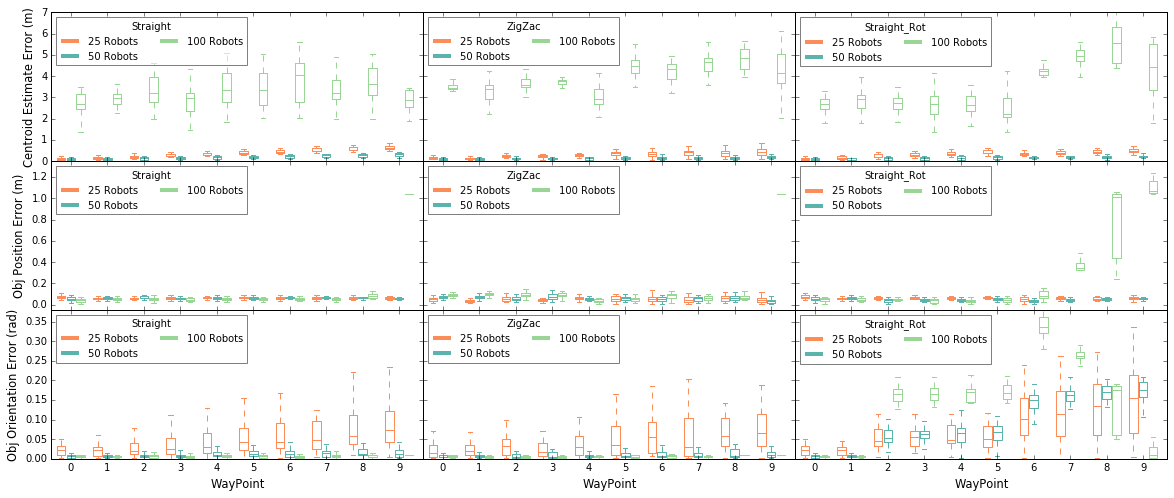

In [113]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    

fig, ax = plt.subplots(3, 3,sharey='row',figsize=(20,8))
plt.subplots_adjust(hspace = 0.0,wspace = 0.0)

titles = ['Straight', 'ZigZac', 'Straight_Rot']
for etype in range(0,3):
    path_num = 0
    for path_num in range(0,len(PATH_TAKEN)):
        path = PATH_TAKEN[path_num]
        robot_1 = []
        robot_2 = []
        robot_3 = []
        for wp in range(0,10):
            robot_1.append((data.stack()[25][0][path][wp][etype]))
            robot_2.append((data.stack()[50][1][path][wp][etype]))
            robot_3.append((data.stack()[100][2][path][wp][etype]))

        lin_1 = ax[etype][path_num].boxplot(robot_1, positions=np.array(xrange(10))*3.0-0.8, sym='', widths=0.7)
        lin_2 = ax[etype][path_num].boxplot(robot_2, positions=np.array(xrange(10))*3.0, sym='', widths=0.7)
        lin_3 = ax[etype][path_num].boxplot(robot_3, positions=np.array(xrange(10))*3.0+0.8, sym='', widths=0.7)

        set_box_color(lin_1, '#fc8d59') # colors are from http://colorbrewer2.org/
        set_box_color(lin_2, '#5ab4ac')
        set_box_color(lin_3, '#99d594')

        # draw temporary red and blue lines and use them to create a legend
        ax[etype][path_num].plot([], c='#fc8d59',linewidth=4, label='25 Robots')
        ax[etype][path_num].plot([], c='#5ab4ac',linewidth=4, label='50 Robots')
        ax[etype][path_num].plot([], c='#99d594',linewidth=4, label='100 Robots')

        ax[etype][path_num].legend(title=titles[path_num], loc=2,ncol=2,framealpha=0.5,fontsize=10)
        ax[etype][path_num].set_xticks(np.array(xrange(10))*3.0)
        ax[etype][path_num].set_xticklabels(range(0,10))
        ax[etype][path_num].set_xlim(-1.6, 29.0)
        if(etype == 0):
            ax[etype][path_num].set_ylim(0, 7.0)
        elif(etype == 1):
            ax[etype][path_num].set_ylim(-0.05, 1.35)
        elif(etype == 2):
            ax[etype][path_num].set_ylim(-0.0001, 0.38)

ax[2][0].set_xlabel("WayPoint",fontsize=11.5)
ax[2][1].set_xlabel("WayPoint",fontsize=11.5)
ax[2][2].set_xlabel("WayPoint",fontsize=11.5)
ax[0][0].set_ylabel("Centroid Estimate Error (m)",fontsize=11.5)
ax[1][0].set_ylabel("Obj Position Error (m)",fontsize=11.5)
ax[2][0].set_ylabel("Obj Orientation Error (rad)",fontsize=11.5)

# plt.gcf().subplots_adjust(bottom=0.18)
plt.savefig("/home/vivek/Vivek/Projects/Collobrative_transport/Data_processing/PLOTS/Error.pdf", dpi=600, format="pdf", transparent=False)

Reading: /collobrative_transport/data/pos_25_straight_0.45_5_0_1.csv
Reading: /collobrative_transport/data/pos_50_straight_0.45_5_1_1.csv
Reading: /collobrative_transport/data/pos_100_straight_0.45_5_2_1.csv
Reading: /collobrative_transport/data/pos_25_zigzac_0.45_5_0_1.csv
Reading: /collobrative_transport/data/pos_50_zigzac_0.45_5_1_1.csv
Reading: /collobrative_transport/data/pos_100_zigzac_0.45_5_2_1.csv
Reading: /collobrative_transport/data/pos_25_straight_rot_0.45_5_0_1.csv
Reading: /collobrative_transport/data/pos_50_straight_rot_0.45_5_1_1.csv
Reading: /collobrative_transport/data/pos_100_straight_rot_0.45_5_2_1.csv


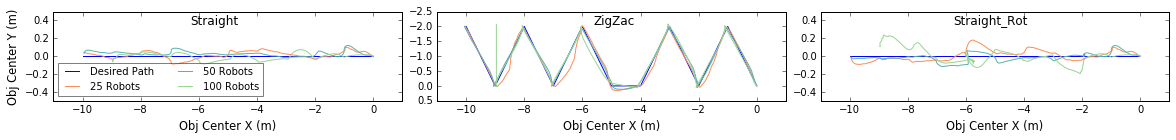

In [139]:
fig, ax = plt.subplots(1, 3,figsize=(20,2))
plt.subplots_adjust(hspace = 0.0,wspace = 0.1)

titles = ['Straight', 'ZigZac', 'Straight_Rot']
robot_types=['25 Robots', '50 Robots', '100 Robots']
m_color = ['#fc8d59','#5ab4ac', '#99d594']
Rand=1
for path_num in range(0,len(PATH_TAKEN)):
    path = PATH_TAKEN[path_num]
    l_path_pnt_x=[]
    l_path_pnt_y=[] 
    for i in range(0,len(PATH_PNT[path_num])-1):
        l_path_pnt_x.append(PATH_PNT[path_num][i][0])
        l_path_pnt_y.append(PATH_PNT[path_num][i][1])
    ax[path_num].plot(l_path_pnt_x,l_path_pnt_y, label='Desired Path')
    ax[path_num].set_xlim(-11, 1)
    ax[path_num].set_ylim(-2.5, 1)
    for i in range(0,len(ROBOTS)):
        obj_shape = 0
        if(ROBOTS[i] == 50):
            obj_shape = 1
        elif(ROBOTS[i] == 100):
            obj_shape = 2 
        p_df = read_pos_datafile(str(ROBOTS[i])+'_'+path+'_'+str(INTER_CAGE_DIST)
                                                           +'_'+str(MASS)+'_'+str(obj_shape)+'_'+str(Rand),ROBOTS[i])
        ax[path_num].plot(p_df['obj_x'],p_df['obj_y'],c=m_color[i],label=robot_types[i])
    if(path_num==1):
        ax[path_num].set_ylim(0.5, -2.5)
    else:
        ax[path_num].set_ylim(-0.5, 0.5)
    

ax[0].legend(loc=3,ncol=2,framealpha=0.5,fontsize=10)

    
plt.figtext(0.22, 0.81, titles[0], color='black', weight='roman',
        size=12)
plt.figtext(0.5, 0.81, titles[1], color='black', weight='roman',
        size=12)
plt.figtext(0.75, 0.81, titles[2], color='black', weight='roman',
        size=12)
ax[0].set_xlabel("Obj Center X (m)",fontsize=11.5)
ax[1].set_xlabel("Obj Center X (m)",fontsize=11.5)
ax[2].set_xlabel("Obj Center X (m)",fontsize=11.5)
ax[0].set_ylabel("Obj Center Y (m)",fontsize=11.5)

plt.gcf().subplots_adjust(bottom=0.28)
plt.savefig("/home/vivek/Vivek/Projects/Collobrative_transport/Data_processing/PLOTS/Center_traj_1.pdf", dpi=600, format="pdf", transparent=False)

In [140]:
%%bash
pdfcrop /home/vivek/Vivek/Projects/Collobrative_transport/Data_processing/PLOTS/Error.pdf /home/vivek/Vivek/Projects/Collobrative_transport/Data_processing/PLOTS/Error.pdf
pdfcrop /home/vivek/Vivek/Projects/Collobrative_transport/Data_processing/PLOTS/Center_traj_1.pdf /home/vivek/Vivek/Projects/Collobrative_transport/Data_processing/PLOTS/Center_traj_1.pdf

PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `/home/vivek/Vivek/Projects/Collobrative_transport/Data_processing/PLOTS/Error.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `/home/vivek/Vivek/Projects/Collobrative_transport/Data_processing/PLOTS/Center_traj_1.pdf'.
